# Creating Radar Charts

In [89]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import pathlib
import warnings
from scipy import stats
from mplsoccer import PyPizza, FontManager, add_image
from pandasql import sqldf
from PIL import Image #to import images

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

In [90]:
train = pd.read_json(r'C:\Users\elvin\Documents\Soccermatics\Wyscout\events\events_Italy.json')

#remove any rows where we do not have the start and end of an action available
mask = train['positions'].apply(lambda x: len(x)==2)
train = train[mask]

## Calculating xG value

In [91]:
def calculatexG(df, npxG):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.
    npxG : boolean
        True if xG should not include penalties, False elsewhere.

    Returns
    -------
    xG_sum: dataframe
        dataframe with sum of Exppected Goals for players during the season.

    """
    #creating a basic xG model
    shots = df[df['eventName']=="Shot"].copy()
    shots["X"] = shots.positions.apply(lambda cell: (100 - cell[0]['x']) * 105/100)
    shots["Y"] = shots.positions.apply(lambda cell: cell[0]['y'] * 68/100)
    shots["C"] = shots.positions.apply(lambda cell: abs(cell[0]['y'] - 50) * 68/100)
    shots["Distance"] = np.sqrt(shots["X"]**2 + shots["C"]**2)
    shots["Angle"] = np.where(np.arctan(7.32 * shots["X"] / (shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) > 0, 
                              np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)), 
                              np.arctan(7.32 * shots["X"] /(shots["X"]**2 + shots["C"]**2 - (7.32/2)**2)) + np.pi)
    shots['Goal'] = shots.tags.apply(lambda x: 1 if {'id':101}in x else 0).astype(object)
    #the header id tag is 403
    headers = shots.loc[shots.apply(lambda x:{'id':403} in x.tags,axis=1)]
    non_headers = shots.drop(headers.index)

    headers_model = smf.glm(formula="Goal ~ Distance + Angle", data=headers,
                            family=sm.families.Binomial()).fit()
    
    non_headers_model = smf.glm(formula="Goal ~ Distance + Angle", data=non_headers,
                            family=sm.families.Binomial()).fit()
    
    #assign xG
    b_head = headers_model.params
    xG = 1/(1+np.exp(b_head[0]+b_head[1]*headers['Distance']+b_head[2]*headers['Angle']))
    headers = headers.assign(xG = xG)

    b_nhead = non_headers_model.params
    xG = 1/(1+np.exp(b_nhead[0]+b_nhead[1]*non_headers['Distance']+b_nhead[2]*non_headers['Angle']))
    non_headers = non_headers.assign(xG = xG)

    if npxG == False:
        penalties = df[df['subEventName']=="Penalty"]
        penalties = penalties.assign(xG = 0.8)
        #concat, group and sum
        xg_df = pd.concat([non_headers[['playerId','xG']],headers[['playerId','xG']],penalties[['playerId','xG']]])
        xG_sum = xg_df.groupby(['playerId'])['xG'].sum().sort_values(ascending=False).reset_index()
    else:
        xg_df = pd.concat([non_headers[['playerId','xG']],headers[['playerId','xG']]])
        xg_df.rename(columns = {"xG": "npxG"},inplace=True)
        xG_sum = xg_df.groupby(['playerId'])['npxG'].sum().sort_values(ascending=False).reset_index()

    return xG_sum

npxG = calculatexG(train,npxG = True)
npxG.head()

,playerId,npxG
0,8327,18.103803
1,206314,15.429168
2,269152,13.851217
3,22933,13.171043
4,21385,12.469877


## Calculating passes ending in final third and receptions in the final third

These stats capture how effective a player is in danger areas. These statistics add context to passes. It isn’t enough for a striker to be a good passer of the ball he or she should be able to perform well in the final third.

To get the information about receptions, the basic idea is that the player who made the next action was the receiver. We filter successful passes that ended in the final third and get the passes as well as the receiver. As in the last step, we sum them by player and merge these dataframes to return one. Note that we use outer join not to forget a player who made no receptions in the final third, bud did make some passes.

In [92]:
def FinalThird(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    final_third: dataframe
        dataframe with number of passes ending in final third and receptions in that area for a player.

    """
    df = df.copy()
    #identifying the players who performed the very next action
    df['nextPlayerId'] = df['playerId'].shift(-1)
    passes = df[df['eventName']=='Pass'].copy()
    #adjusting the coordinates
    passes['x'] = passes.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
    passes['y'] = passes.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
    passes['end_x'] = passes.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
    passes['end_y'] = passes.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)

    #get accurate passes. the tagid for accurate passes in wyscout is 1801
    accurate_passes = passes[passes.apply(lambda x:{'id':1801}in x.tags,axis=1)]
    #for passes that were received in the final third:
    final_third_passes = accurate_passes[accurate_passes['end_x'] > 2*105/3] #or "end_x" > 70

    #number of final third passes by player
    ftp_player = final_third_passes.groupby(['playerId']).end_x.count().reset_index()
    ftp_player.rename(columns = {'end_x':'final_third_passes'},inplace=True)

    #number of final third receptions by player
    rtp_player = final_third_passes.groupby(["nextPlayerId"]).end_x.count().reset_index()
    rtp_player.rename(columns = {'end_x':'final_third_receptions', "nextPlayerId": "playerId"}, inplace=True)
    
    #joining both tables with an outer join so we can keep players who only received the ball in the final third or only made passes in the final third
    final_third = ftp_player.merge(rtp_player,how='outer',on=['playerId'])
    return final_third

final_third = FinalThird(train)
final_third.head()


,playerId,final_third_passes,final_third_receptions
0,0.0,3.0,20.0
1,45.0,25.0,21.0
2,114.0,439.0,293.0
3,122.0,427.0,727.0
4,130.0,143.0,82.0


## Calculating air and ground duels won

In [93]:
def wonDuels(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    duels_won: dataframe
        dataframe with number of won air and ground duels for a player

    """
    #finding air duels
    air_duels = df[df['subEventName']=="Air duel"]
    #the tagid for won duels is 703
    wad = air_duels[air_duels.apply(lambda x:{"id":703}in x.tags,axis=1)]

    wad_player = wad.groupby('playerId').eventId.count().reset_index()
    wad_player.rename(columns = {'eventId':'air_duels_won'}, inplace = True)

    #calculating ground duels won
    ground_duels = df[df['subEventName'].isin(['Ground attacking duel', 'Ground defending duel', 'Ground loose ball duel'])]
    wgd = ground_duels[ground_duels.apply(lambda x:{'id':703}in x.tags,axis=1)]
    wgd_player = wgd.groupby('playerId').eventId.count().reset_index()
    wgd_player.rename(columns={'eventId':'ground_duels_won'},inplace=True)

    duels_won = wad_player.merge(wgd_player,how='outer',on=['playerId'])
    return duels_won

duels = wonDuels(train)
duels.head()


,playerId,air_duels_won,ground_duels_won
0,0,893.0,5057.0
1,45,7.0,14.0
2,114,32.0,139.0
3,122,5.0,210.0
4,130,49.0,99.0


## Calculating smart passes

In [94]:
def smartPasses(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    sp_player: dataframe
        dataframe with number of smart passes.
        """
    
    sp = df[df['subEventName']=='Smart pass']
    #finding accurate smart passes
    sp_made = sp[sp.apply(lambda x: {'id':1801}in x.tags, axis=1)]

    #sum up passes by player
    sp_player = sp_made.groupby('playerId').eventId.count().reset_index()
    sp_player.rename(columns={'eventId':'smart_passes'}, inplace=True)

    return sp_player

smart_passes = smartPasses(train)
smart_passes.head(3)


,playerId,smart_passes
0,114,12
1,122,33
2,174,7


## Calculating Goals, Assists and Key Passes 

In [95]:
def GAKP(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    data: dataframe
        dataframe with number of (non-penalty) goals, assists and key passes.
    """

    #calculating goals
    shots = df[df['subEventName']=='Shot'].copy()
    goals = shots[shots.apply(lambda x: {'id':101}in x.tags, axis=1)]
    goals_player = goals.groupby('playerId')['eventId'].count().reset_index()
    goals_player.rename(columns={'eventId':'goals'},inplace=True)
    
    #calculating assists
    passes = df[df['eventName']=='Pass'].copy()
    assists = passes[passes.apply(lambda x:{'id':301} in x.tags, axis=1)]
    assists_player = assists.groupby('playerId')['eventId'].count().reset_index()
    assists_player.rename(columns={'eventId':'assists'},inplace=True)

    #calculating key passes
    key_passes = passes[passes.apply(lambda x:{'id':302} in x.tags, axis=1)]
    kp_player = key_passes.groupby('playerId')['eventId'].count().reset_index()
    kp_player.rename(columns={'eventId':'key_pass'},inplace=True)

    data = goals_player.merge(assists_player,how='outer',on=['playerId']).merge(kp_player,how='outer',on=['playerId'])
    return data

gakp = GAKP(train)
gakp.head(3)

,playerId,goals,assists,key_pass
0,45,NaN,NaN,1.0
1,114,1.0,NaN,5.0
2,122,13.0,6.0,29.0


## Minutes played

All data on our plot will be per 90 minutes played. Therefore, we need an information on the number of minutes played throughout the season. To do so, we will use a prepared file that bases on the idea developed by students taking part in course in 2021. Files with miutes per game for players in top 5 leagues can be found here. After downloading data and saving it in out directory, we open it and store in a dataframe. Then we calculate the sum of miutes played in a season for each player.

In [96]:
mins_per_game = pd.read_json(r"C:\Users\elvin\Documents\Soccermatics\Wyscout\minutes_played_per_game_Italy.json")
mins = mins_per_game.groupby('playerId').minutesPlayed.sum().reset_index()

In [ ]:
#creating a summary table to house all of the data gathered so far

players = train["playerId"].unique()
summary = pd.DataFrame(players, columns = ["playerId"])
summary = summary.merge(npxG, how = "left", on = ["playerId"]).merge(final_third, how = "left", on = ["playerId"]).merge(duels, how = "left", on = ["playerId"]).merge(smart_passes, how = "left", on = ["playerId"]).merge(gakp, how = "left", on = ["playerId"])

summary = mins.merge(summary, how = "left", on = ["playerId"])
summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]

#filtering for player positions
player_df = pd.read_json(r"C:\Users\elvin\Documents\Soccermatics\Wyscout\players.json")
forwards = player_df[player_df.apply(lambda x: x.role['name']=='Forward', axis=1)]
forwards.rename(columns={'wyId':'playerId'},inplace=True)
to_merge = forwards[['playerId','shortName']]
summary = summary.merge(to_merge,how='inner',on=['playerId'])
#rearranging the columns in summary
summary = summary[['playerId','shortName', 'minutesPlayed', 'npxG', 'final_third_passes',
       'final_third_receptions', 'air_duels_won', 'ground_duels_won',
       'smart_passes', 'goals', 'assists', 'key_pass']]


In [125]:
# converting inputs to per90
forwards_summary = forwards_summary.merge(to_merge,how='inner',on=['playerId'])
fs_per_90 = forwards_summary.copy()
fs_per_90 = fs_per_90[['shortName', 'minutesPlayed', 'npxG', 'final_third_passes',
       'final_third_receptions', 'air_duels_won', 'ground_duels_won',
       'smart_passes', 'goals', 'assists', 'key_pass']]
fs_per_90.iloc[:,2:] = fs_per_90.iloc[:,2:].div(fs_per_90['minutesPlayed'],axis=0).mul(90) 
fs_per_90.rename(columns = {c:c+"_per90" for c in fs_per_90.columns[2:]} ,inplace=True)

#player to invesitgate - Paulo Dybala
dybala = fs_per_90[fs_per_90['shortName']=="P. Dybala"]
dybala = dybala[['npxG_per90', 'goals_per90','assists_per90','key_pass_per90', 'smart_passes_per90', 'final_third_passes_per90',
       'final_third_receptions_per90', 'ground_duels_won_per90','air_duels_won_per90']]

values = [round(dybala[col].iloc[0],2)for col in dybala.columns]

percentiles = [int(stats.percentileofscore(fs_per_90[col],dybala[col].iloc[0]))for col in dybala.columns]



## Making radar charts

In [126]:
#Loading image

dybala_cropped = Image.open(r"C:\Users\elvin\Documents\Soccermatics\Wyscout\dybala-modified.png")

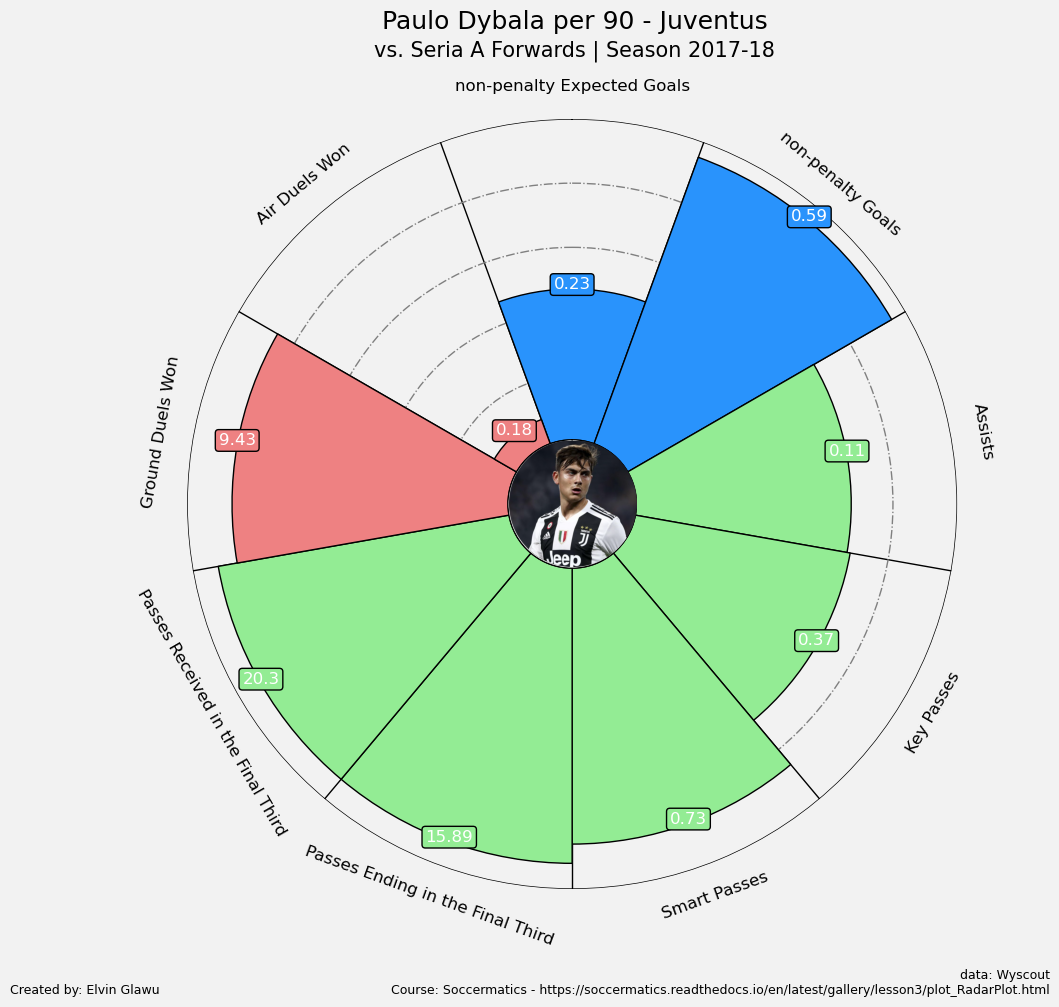

In [127]:
#list the names on the plot
names = ["non-penalty Expected Goals","non-penalty Goals","Assists","Key Passes","Smart Passes","Passes Ending in the Final Third",
         "Passes Received in the Final Third", "Ground Duels Won","Air Duels Won"]
slice_colors = ["#2993fc"] * 2 + ["#93ec94"] * 5 + ["#ee8182"] * 2
text_colors = ["#ffffff"]*9

#PIZZA PLOT
baker = PyPizza(
    params=names,
    min_range= None,
    max_range= None,
    straight_line_color= "#000000",     # gives color for straight lines
    straight_line_lw=1,                   # linewidth for straight lines
    last_circle_lw=1,                  # linewidth of last circle
    other_circle_lw=1,                    # linewidth of other circles
    other_circle_ls="-.",
    inner_circle_size=20                  # linestyle for other circles
)

fig, ax =  baker.make_pizza(
    percentiles,
    figsize=(10,10),
    param_location=110,
    slice_colors=slice_colors,
    value_colors=text_colors,
    value_bck_colors = slice_colors,
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor = "#000000",
        zorder=2, linewidth=1
    ),
    kwargs_params=dict(
        color="#000000", fontsize=12, va="center"
    ),
    kwargs_values=dict(
        color="#000000",fontsize=12,
        bbox=dict(
            edgecolor="#000000",facecolor="cornflowerblue",
            boxstyle="round,pad=0.2",lw=1
        )
    )
)

#putting in text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    val = values[i]
    pct = percentiles[i]
    text.set_text(f"{val}")

#add title
fig.text(
    0.515, 0.97, 
    "Paulo Dybala per 90 - Juventus",
    size=18,
    ha="center"
)

fig.text(
    0.515,0.942,
    "vs. Seria A Forwards | Season 2017-18",
    size=15,
    ha="center",color="black"
)

#add image
ax_image = add_image(
    dybala_cropped, fig, left=0.4478, bottom=0.4315, width=0.13, height=0.127
)

#add_credits
CREDIT_1 = "data: Wyscout"
CREDIT_2 = "Course: Soccermatics - https://soccermatics.readthedocs.io/en/latest/gallery/lesson3/plot_RadarPlot.html"

fig.text(
    0.99,0.005,
    f"{CREDIT_1}\n{CREDIT_2}",size=9,
    color="#000000",
    ha="right"
)

fig.text(
    0.1,0.005,
    "Created by: Elvin Glawu",size=9,
    color="#000000",
    ha="right"
)
plt.show()

## Calculating possession
Here, we calculate possession by taking the number of touches by a team and dividing it by the total number of touches in the game.
As the next step we would like to adjust our plot by the player’s team ball possesion while they were on the pitch. To do it, for each row of our dataframe with minutes per player per each game we take all the events that were made in this game while the player was on the pitch. We will also use duels, but don’t include lost air duels and lost ground defending duels. Why? Possesion is calculated as number of touches by team divided by the number all touches. If a player lost ground defending duel, that means that he could have been dribbled by, so he did not touch the ball. If they lost the air duel, they lost a header. Therefore, we claim that those were mostly events where player may have not touched the ball (or if he did the team did not take control over it). We sum both team passes and these duels and all passes and these duels in this period. We store these values in a dictionary. Then, summing them for each player separately and calculating their ratio, we get the possesion of the ball by player’s team while he was on the pitch. As the last step we merge it with our summary dataframe.

In [128]:
possession_dict = {}
#for every row in the dataframe
for i, row in mins_per_game.iterrows():
    #take player id, team id, match id, minute in and minute out
    player_id, team_id, match_id = row["playerId"], row["teamId"], row["matchId"]
    #create a key in dictionary if player is encounted for the first time
    if not str(player_id) in possession_dict.keys():
        possession_dict[str(player_id)] = {'team_touches': 0, 'all_touches':0}
    min_in = row['player_in_min']*60
    min_out = row['player_out_min']*60

    #get df of events in each game
    match_df = train[train['matchId']==match_id].copy()
    #adds the latest time in the first half to every time in the second half so that we can have a continuous flow of events in a game.
    match_df.loc[match_df['matchPeriod']=="2H", 'eventSec'] = match_df.loc[match_df['matchPeriod']=="2H", 'eventSec']+ match_df.loc[match_df['matchPeriod']=="1H"]['eventSec'].iloc[-1]
    #slices for only events that occured when player was on the pitch
    player_in_match_df = match_df[(match_df['eventSec']> min_in) & (match_df['eventSec']<= min_out)]
    #take all touches from passes and duels
    all_touches = player_in_match_df[player_in_match_df['eventName'].isin(["Pass","Duel"])]
    #removing all lost duels
    if len(all_touches) > 0:
        no_contact = all_touches[all_touches['subEventName'].isin(["Air duel","Ground defending duel","Ground loose ball duel"])].loc[all_touches.apply(lambda x:{'id':701}in x.tags, axis=1)]
        all_touches = all_touches.drop(no_contact.index)
    #take team passes
    team_touches = all_touches[all_touches['teamId']==team_id]
    #append it {player id: {team passes: sum, all passes: sum}}
    possession_dict[str(player_id)]['team_touches'] += len(team_touches)
    possession_dict[str(player_id)]['all_touches'] += len(all_touches)

    #calculate possession for each player
    percentage_dict = {key: value["team_touches"]/value["all_touches"] if value["all_touches"] > 0 else 0 for key, value in possession_dict.items()}

    #create a dataframe
    percentage_df = pd.DataFrame(percentage_dict.items(), columns = ['playerId','possession'])
    percentage_df['playerId'] = percentage_df['playerId'].astype(int)

    #merge with summary
    if 'possession' in summary.columns:
        summary = summary.drop(columns=['possession'])
    summary = summary.merge(percentage_df, how="left", on =["playerId"])

In [141]:
#Adjusting the data for posession
summary_adjusted = pd.DataFrame()
summary_adjusted['shortName'] = summary['shortName']

for column in summary.columns[3:12]:
    summary_adjusted[column+"_adjusted_per90"] = summary.apply(lambda x: (x[column]/x['possession'])*90/x['minutesPlayed'],axis=1)

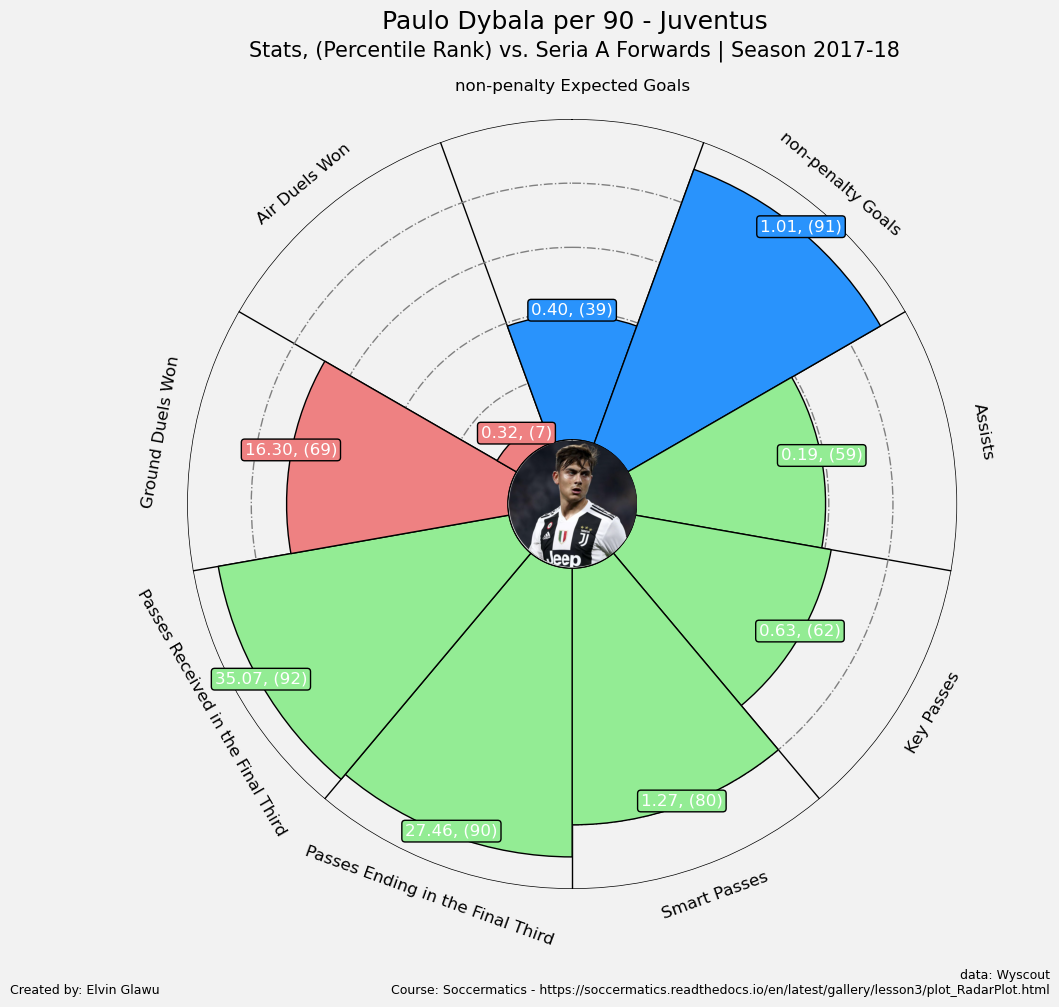

In [148]:
dybala_adjusted = summary_adjusted.loc[summary_adjusted["shortName"] == "P. Dybala"]
dybala_adjusted = dybala_adjusted[['npxG_adjusted_per90', "goals_adjusted_per90", "assists_adjusted_per90", "key_pass_adjusted_per90", "smart_passes_adjusted_per90", "final_third_passes_adjusted_per90", "final_third_receptions_adjusted_per90", "ground_duels_won_adjusted_per90", "air_duels_won_adjusted_per90"]]
#take only necessary columns
adjusted_columns = dybala_adjusted.columns[:]
#values
values = [dybala_adjusted[column].iloc[0] for column in adjusted_columns]
#percentiles
percentiles = [int(stats.percentileofscore(summary_adjusted[column], dybala_adjusted[column].iloc[0])) for column in adjusted_columns]


#list the names on the plot
names = ["non-penalty Expected Goals","non-penalty Goals","Assists","Key Passes","Smart Passes","Passes Ending in the Final Third",
         "Passes Received in the Final Third", "Ground Duels Won","Air Duels Won"]
slice_colors = ["#2993fc"] * 2 + ["#93ec94"] * 5 + ["#ee8182"] * 2
text_colors = ["#ffffff"]*9

#PIZZA PLOT
baker = PyPizza(
    params=names,
    min_range= None,
    max_range= None,
    straight_line_color= "#000000",     # gives color for straight lines
    straight_line_lw=1,                   # linewidth for straight lines
    last_circle_lw=1,                  # linewidth of last circle
    other_circle_lw=1,                    # linewidth of other circles
    other_circle_ls="-.",
    inner_circle_size=20                  # linestyle for other circles
)

fig, ax =  baker.make_pizza(
    percentiles,
    figsize=(10,10),
    param_location=110,
    slice_colors=slice_colors,
    value_colors=text_colors,
    value_bck_colors = slice_colors,
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor = "#000000",
        zorder=2, linewidth=1
    ),
    kwargs_params=dict(
        color="#000000", fontsize=12, va="center"
    ),
    kwargs_values=dict(
        color="#000000",fontsize=12,
        bbox=dict(
            edgecolor="#000000",facecolor="cornflowerblue",
            boxstyle="round,pad=0.2",lw=1
        )
    )
)

#putting in text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    val = values[i]
    pct = percentiles[i]
    text.set_text(f"{val:.2f}, ({pct})")

#add title
fig.text(
    0.515, 0.97, 
    "Paulo Dybala per 90 - Juventus",
    size=18,
    ha="center"
)

fig.text(
    0.515,0.942,
    "Stats, (Percentile Rank) vs. Seria A Forwards | Season 2017-18",
    size=15,
    ha="center",color="black"
)

#add image
ax_image = add_image(
    dybala_cropped, fig, left=0.4478, bottom=0.4315, width=0.13, height=0.127
)

#add_credits
CREDIT_1 = "data: Wyscout"
CREDIT_2 = "Course: Soccermatics - https://soccermatics.readthedocs.io/en/latest/gallery/lesson3/plot_RadarPlot.html"

fig.text(
    0.99,0.005,
    f"{CREDIT_1}\n{CREDIT_2}",size=9,
    color="#000000",
    ha="right"
)

fig.text(
    0.1,0.005,
    "Created by: Elvin Glawu",size=9,
    color="#000000",
    ha="right"
)
plt.show()

In [143]:
summary_adjusted

,shortName,npxG_adjusted_per90,final_third_passes_adjusted_per90,final_third_receptions_adjusted_per90,air_duels_won_adjusted_per90,ground_duels_won_adjusted_per90,smart_passes_adjusted_per90,goals_adjusted_per90,assists_adjusted_per90,key_pass_adjusted_per90
0,D. Mertens,0.475564,20.118299,34.252936,0.235577,9.894246,1.554810,0.612501,0.282693,1.366348
1,S. Armenteros,0.430936,9.156249,15.421050,4.337170,8.674341,0.481908,0.481908,0.000000,0.481908
2,Jos\u00e9 Callej\u00f3n,0.301560,21.409420,30.584886,0.742776,5.723743,0.524312,0.349542,0.218463,0.873854
3,G. Higua\u00edn,0.536607,12.909008,22.700162,0.711089,11.924422,0.546992,0.820488,0.218797,0.328195
4,D. Perotti,0.192228,31.815834,32.668044,1.041590,23.672496,1.893800,0.284070,0.378760,1.515040
...,...,...,...,...,...,...,...,...,...,...
91,Y. Karamoh,0.440450,25.590323,36.046584,0.825494,15.134062,1.375824,0.275165,0.000000,0.550330
92,R. Orsolini,0.241415,14.089676,27.843884,3.690153,15.431550,1.006405,0.000000,0.000000,2.012811
93,M. Kean,0.980573,10.324980,16.778093,2.396870,14.934347,0.000000,0.737499,0.000000,0.553124
94,E. Brignola,0.282778,15.019055,24.375188,0.738642,15.142162,0.861749,0.369321,0.246214,0.492428
